In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates

In [3]:
beta = pd.read_csv('saved_model/implied_vol_model.csv')
beta['as_of'] = pd.to_datetime(beta['as_of'])
sp = pd.read_csv('db.csv', usecols=['as_of', 'as_of_stock_price'])
sp['as_of'] = pd.to_datetime(sp['as_of'])
sp.rename(columns={'as_of_stock_price':'sp'}, inplace=True)
sp = sp.drop_duplicates().sort_values(by='as_of')
beta = beta.set_index('as_of')
sp = sp.set_index('as_of')
sp['sp'] = np.log(sp['sp'])
sp = sp.diff().fillna(0)
beta = beta.join(sp)
beta

,beta_1,beta_2,beta_3,beta_4,beta_5,sp
as_of,,,,,,
2022-12-28,0.225037,-0.004810,0.237171,0.019645,-0.036282,-0.012506
2022-12-29,0.220774,-0.013869,0.235247,0.014646,-0.035924,0.017840
2022-12-30,0.220796,-0.009517,0.235147,0.014203,-0.038308,-0.002638
2023-01-03,0.217816,0.003820,0.252269,0.019653,-0.041226,-0.004219
2023-01-04,0.217418,-0.013587,0.256800,0.022648,-0.041456,0.007691
...,...,...,...,...,...,...
2023-04-13,0.191567,-0.077315,0.306413,0.011964,-0.049011,0.013195
2023-04-14,0.189684,-0.072816,0.315266,0.023284,-0.053008,-0.002446
2023-04-17,0.188395,-0.082267,0.313210,0.015214,-0.051931,0.003582


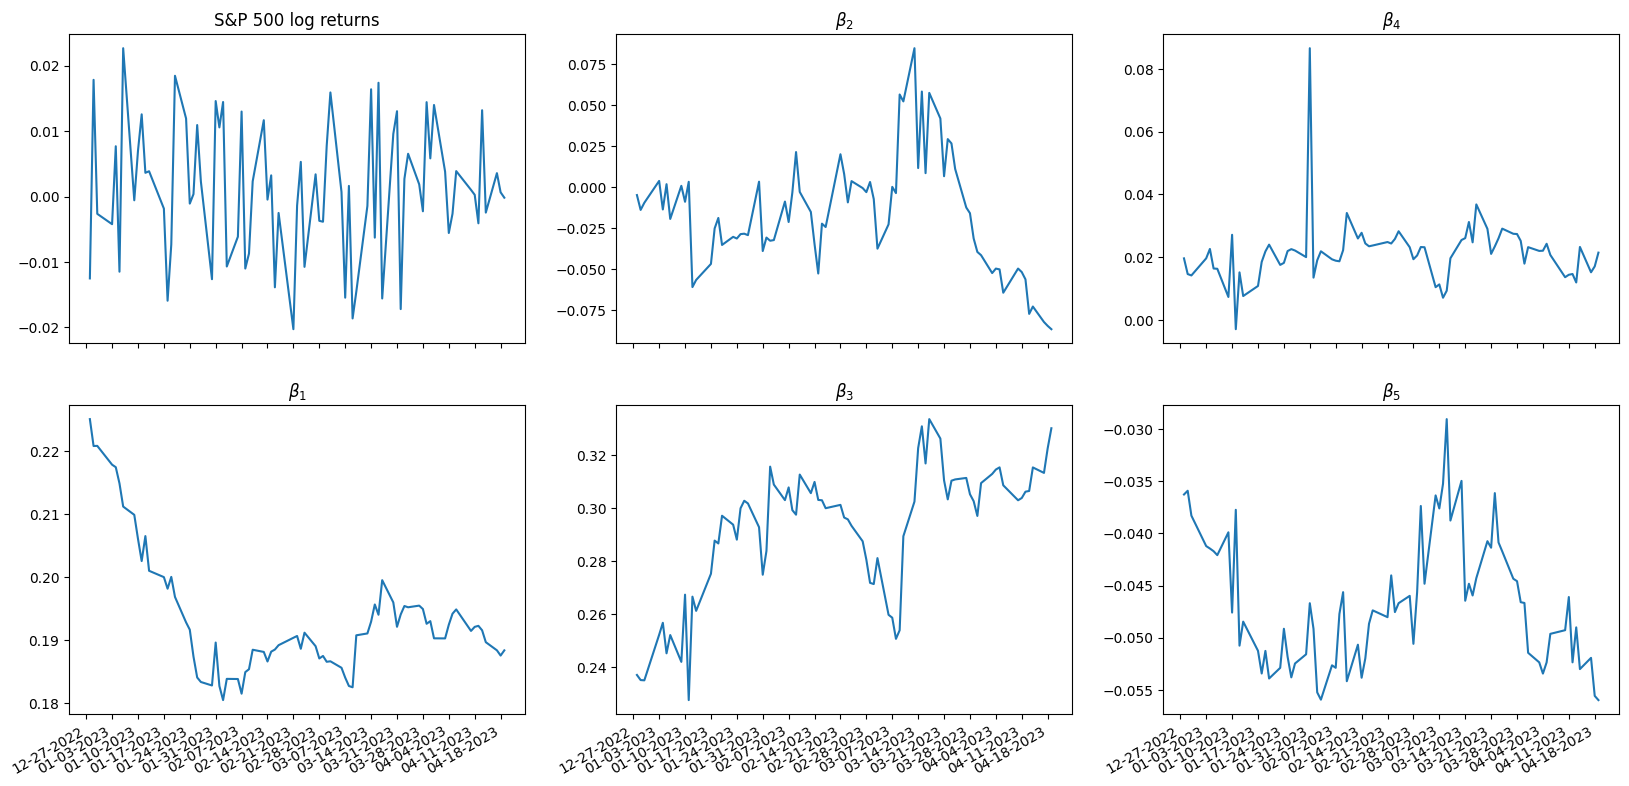

In [5]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=3, sharex='row')
ax[0, 0].plot(beta['sp'])
ax[0, 0].set_title('S&P 500 log returns')
ax[0, 0].xaxis.set_major_locator(pltdates.WeekdayLocator(byweekday=1, interval=1))
ax[0, 0].xaxis.set_major_formatter(pltdates.DateFormatter('%m-%d-%Y'))
for i in range(1, 6):
    ax[i%2, i//2].plot(beta['beta_'+str(i)])
    ax[i%2, i//2].set_title(fr'$\beta_{i}$')
    ax[i%2, i//2].xaxis.set_major_locator(pltdates.WeekdayLocator(byweekday=1, interval=1))
    ax[i%2, i//2].xaxis.set_major_formatter(pltdates.DateFormatter('%m-%d-%Y'))
plt.gcf().autofmt_xdate()

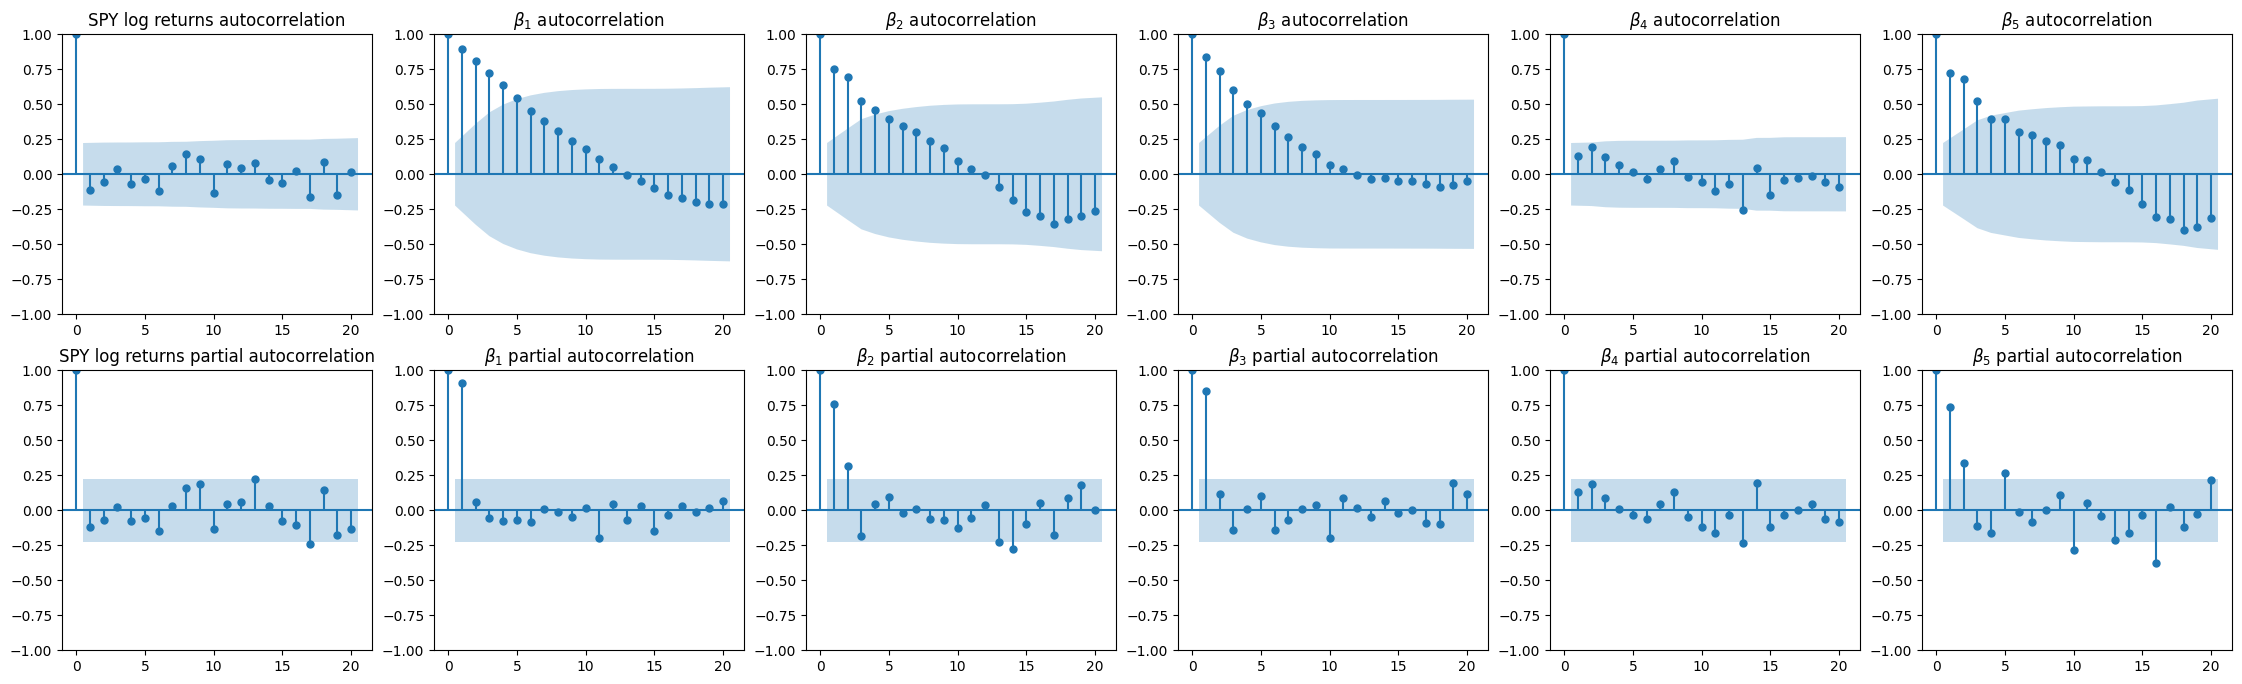

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(28, 8), nrows=2, ncols=6, sharex=False, sharey=False)
_ = plot_acf(beta['sp'], lags=20, ax=ax[0, 0], title='SPY log returns autocorrelation')
_ = plot_pacf(beta['sp'], lags=20, ax=ax[1, 0], title='SPY log returns partial autocorrelation')
for i in range(1, 6):
    _ = plot_acf(beta['beta_'+str(i)], lags=20, ax=ax[0, i], title=fr'$\beta_{i}$ autocorrelation')
    _ = plot_pacf(beta['beta_'+str(i)], lags=20, ax=ax[1, i], title=fr'$\beta_{i}$ partial autocorrelation')
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

adftest = pd.DataFrame(data={'sp':[], 'beta_1':[], 'beta_2':[], 'beta_3':[], 'beta_4':[], 'beta_5':[]})
for col in beta.columns:
    adf = adfuller(beta[col], autolag='AIC', maxlag=3, regression='c')
    adf_s = pd.Series(adf[0:4], index=['Test Statistic','p-value','# lags used', '# obs used'])
    for key,value in adf[4].items():
        adf_s['critical value (%s)'%key]= value
    adftest[col] = adf_s
adftest.rename(columns={'beta_1':r'$\beta_1$', 'beta_2':r'$\beta_2$', 'beta_3':r'$\beta_3$', 'beta_4':r'$\beta_4$', 'beta_5':r'$\beta_5$'}, inplace=True)
adftest.head(10)

,sp,$\beta_1$,$\beta_2$,$\beta_3$,$\beta_4$,$\beta_5$
Test Statistic,-9.777583e+00,-3.561697,-1.371282,-2.242859,-4.671524,-2.122309
p-value,6.868996e-17,0.006537,0.595964,0.191059,0.000095,0.235639
# lags used,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000
# obs used,7.600000e+01,76.000000,75.000000,75.000000,75.000000,75.000000
critical value (1%),-3.519481e+00,-3.519481,-3.520713,-3.520713,-3.520713,-3.520713
critical value (5%),-2.900395e+00,-2.900395,-2.900925,-2.900925,-2.900925,-2.900925
critical value (10%),-2.587498e+00,-2.587498,-2.587781,-2.587781,-2.587781,-2.587781


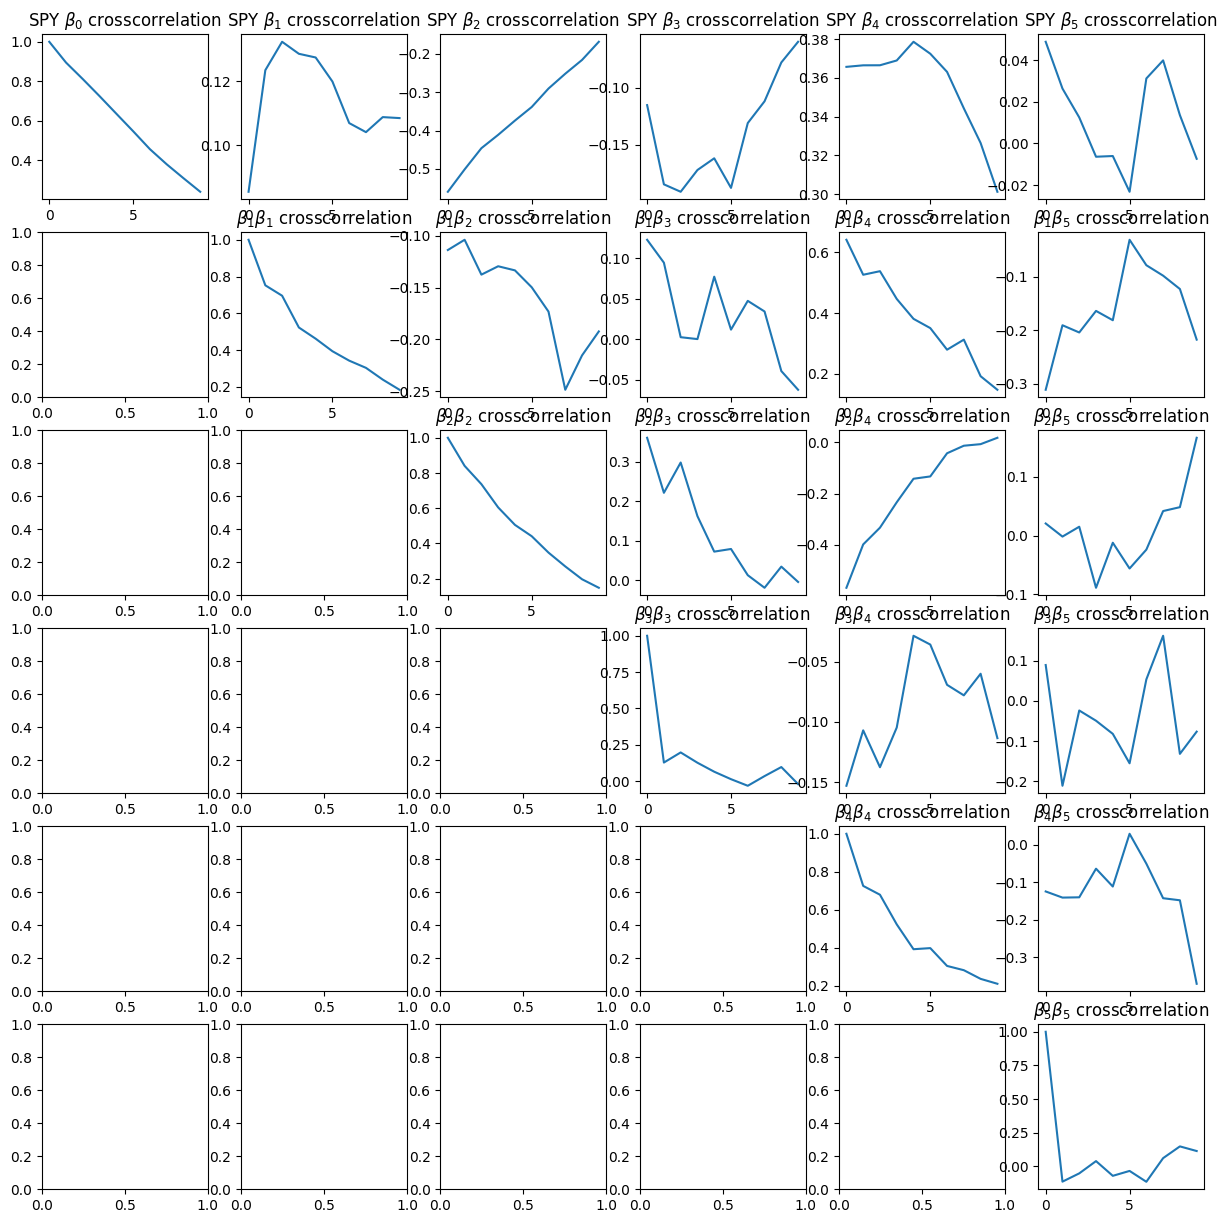

In [22]:
from statsmodels.tsa.stattools import ccf

fig, ax = plt.subplots(figsize=(15, 15), nrows=6, ncols=6, sharex=False, sharey=False)
for i in range(6):
    for j in range(i, 6):
        ax[i, j].plot(ccf(beta.iloc[:, i], beta.iloc[:, j], adjusted=False)[:10])
        if i == 0:
            ax[i, j].set_title(fr'SPY $\beta_{j}$ crosscorrelation')
        else:
            ax[i, j].set_title(fr'$\beta_{i} \beta_{j}$ crosscorrelation')
plt.show()

In [5]:
beta = pd.read_csv('results/predicted_beta.csv').rename(columns={'Unnamed: 0':'as_of'})
h = pd.read_csv('results/predicted_h.csv').rename(columns={'Unnamed: 0':'as_of'})
beta['as_of'] = pd.to_datetime(beta['as_of'])
h['as_of'] = pd.to_datetime(h['as_of'])
beta = beta.set_index('as_of')
h = h.set_index('as_of')

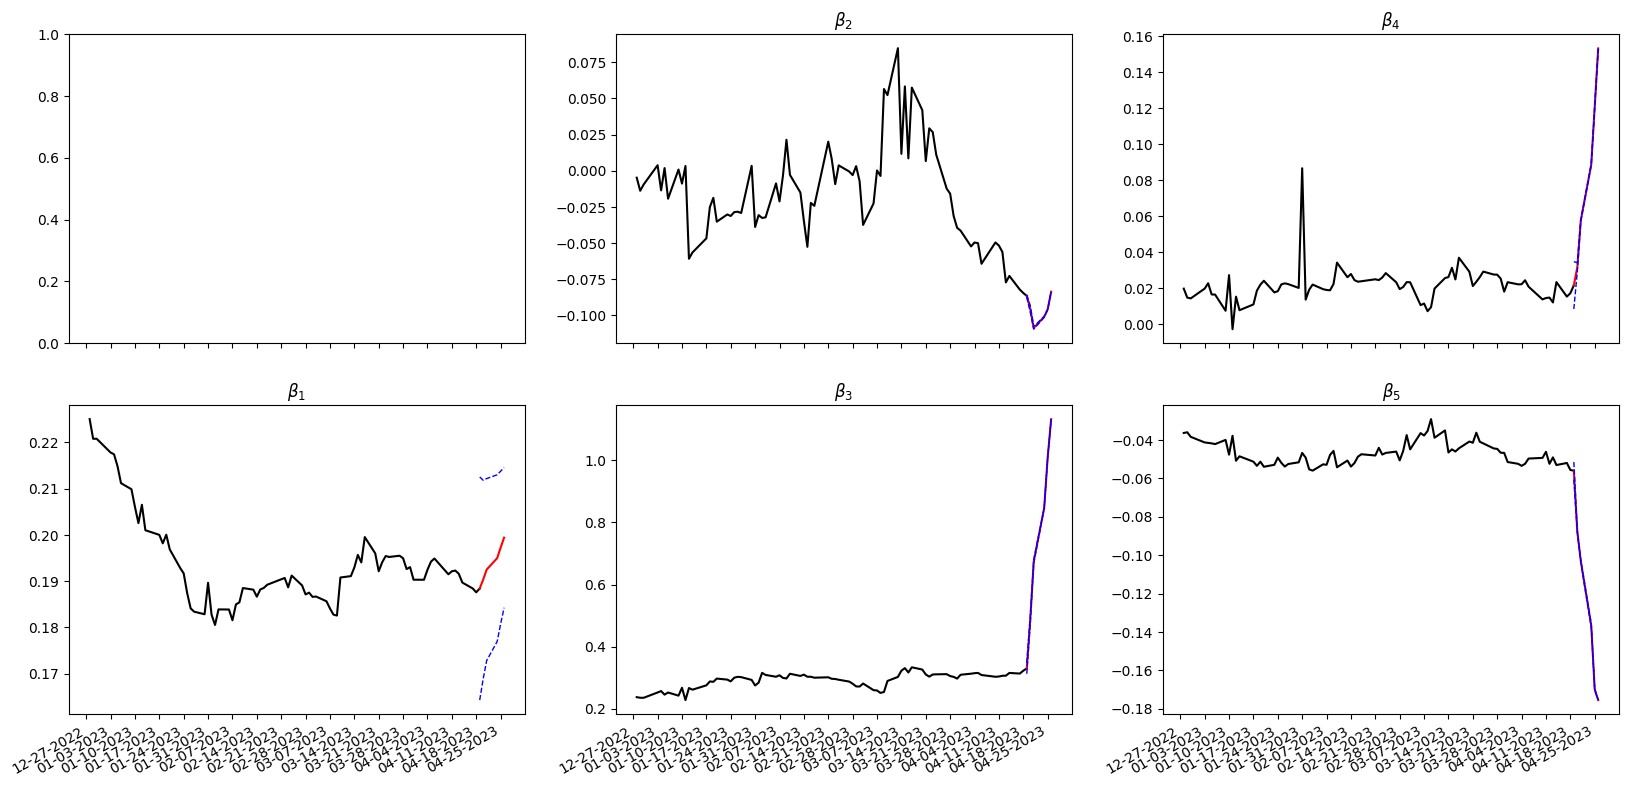

In [18]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=3, sharex='row')
for i in range(1, 6):
    ax[i%2, i//2].plot(beta.loc[:pd.Timestamp(year=2023, month=4, day=19), 'beta_'+str(i)], color='black')
    ax[i%2, i//2].plot(beta.loc[pd.Timestamp(year=2023, month=4, day=19):pd.Timestamp(year=2023, month=4, day=26), 'beta_'+str(i)], color='red')
    ax[i%2, i//2].plot(beta.loc[pd.Timestamp(year=2023, month=4, day=19):pd.Timestamp(year=2023, month=4, day=26), 'beta_'+str(i)] + 1.96*h.loc[pd.Timestamp(year=2023, month=4, day=19):pd.Timestamp(year=2023, month=4, day=26), 'h_beta_'+str(i)], color='blue', linestyle='dashed', linewidth=1)
    ax[i%2, i//2].plot(beta.loc[pd.Timestamp(year=2023, month=4, day=19):pd.Timestamp(year=2023, month=4, day=26), 'beta_'+str(i)] - 1.96*h.loc[pd.Timestamp(year=2023, month=4, day=19):pd.Timestamp(year=2023, month=4, day=26), 'h_beta_'+str(i)], color='blue', linestyle='dashed', linewidth=1)
    ax[i%2, i//2].set_title(fr'$\beta_{i}$')
    ax[i%2, i//2].xaxis.set_major_locator(pltdates.WeekdayLocator(byweekday=1, interval=1))
    ax[i%2, i//2].xaxis.set_major_formatter(pltdates.DateFormatter('%m-%d-%Y'))
plt.gcf().autofmt_xdate()
# plt.plot(beta['beta_1'])
# plt.plot(beta['beta_1']+1.96*h['h_beta_1'])
# plt.plot(beta['beta_1']-1.96*h['h_beta_1'])